[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DSSHN_lRd0A_tPBwYBi6zlOd_9N1DBJ3#scrollTo=dpz7yKFTYXPZ)

## HW Requirement

• Rewrite the code you have for the weight-
tuning_LG in HW #2 into the code of the weight-
tuning_LG_UA. \
• Rewrite the code you have for the weight-
tuning_EB_LG in HW #2 into the code of the 
weight-tuning_EB_LG_UA. \
• Once you have the code, you will apply the code 
to learn your dataset for HW #1.\
• The training and test dataset is 80%/20%. \
• The performance comparison benchmark is the 
best code of the weight-tuning_EB for HW #1.

## Model

In [4]:
import torch
from torch import nn, optim, Generator, backends
from torch.utils.data import DataLoader, Dataset, random_split
from typing import Iterable, Callable, Type, Optional, Union, Tuple, List


In [5]:
from operator import mul

def product(nums: Iterable[Type], func: Callable[[Type, Type], Type] = mul):
    def _product(nums):
        nonlocal func
        if len(nums) == 1:
            return nums[0]
        return func(nums[-1], _product(nums[:-1]))
    try:
        return _product(nums)
    except Exception as e:
        raise e

In [6]:
class TwoLayerNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, init_method: Callable, active_func: Callable[[], nn.modules.module.Module]) -> None:
        super(TwoLayerNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # first layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # activation
        self.active_func = active_func()
        # initialize
        for param in self.parameters():
            init_method(param)
        # second layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.active_func(out)
        out = self.fc2(out)
        return out


In [7]:
def validate(model: nn.Module, device: str, valloader: DataLoader[Dataset[torch.Tensor]], criterion: nn.modules.loss._Loss) -> Tuple[float, float]:
    # Validate the model
    model.to(device)
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for X, y in valloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y).sum().item()
        val_loss /= len(valloader.dataset)
        val_accuracy = val_correct / len(valloader.dataset)
    return val_loss, val_accuracy


In [20]:
def train(model: TwoLayerNetwork, opt: Callable[..., optim.Optimizer], device: str, epochs: Union[int, float], learning_rate: float, trainloader: DataLoader[Dataset[torch.Tensor]], valloader: DataLoader[Dataset[torch.Tensor]], criterion: nn.modules.loss._Loss,
          sched: Optional[Callable[[optim.Optimizer], optim.lr_scheduler._LRScheduler]], weight_decay: float, learning_goal: float, min_lr: float) -> List[Tuple[float, float, float, float]]:
    if epochs < 1:
        raise ValueError("Invalid epoch!!")
    model.to(device)
    init_lr = learning_rate
    optimizer = opt(model.parameters(), lr=learning_rate,
                    weight_decay=weight_decay)
    scheduler = sched(optimizer) if sched else None
    history = []
    # pre_loss = validate(
    #     model=model, device=device, valloader=trainloader, criterion=criterion)[0]
    pre_loss = float("inf")
    # Train the model
    epoch = 0
    while epoch < epochs:
        train_loss = 0.0
        train_correct = 0
        model.train()
        for X, y in trainloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pre_params = list(model.parameters())
            outputs = model(X)
            loss_all = criterion(outputs, y)
            loss_all.backward()
            optimizer.step()
            while pre_loss <= loss_all.item():
                # print(loss_all.item(), learning_rate)
                if learning_rate < min_lr:
                    # return history
                    # print(learning_rate)
                    learning_rate = init_lr
                    optimizer = opt(pre_params, lr=learning_rate,
                                    weight_decay=weight_decay)
                    optimizer.zero_grad()
                    outputs = model(X)
                    loss_all = criterion(outputs, y)
                    loss_all.backward()
                    optimizer.step()
                    # raise ValueError(f"{learning_rate} < {min_lr}")
                    break
                learning_rate *= 0.7
                optimizer = opt(pre_params, lr=learning_rate,
                                weight_decay=weight_decay)
                optimizer.zero_grad()
                outputs = model(X)
                loss_all = criterion(outputs, y)
                loss_all.backward()
                optimizer.step()
            learning_rate *= 1.2
            train_loss += loss_all.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == y).sum().item()
            pre_loss = loss_all.item()
        train_loss /= len(trainloader.dataset)
        train_accuracy = train_correct / len(trainloader.dataset)
        # Validate the model
        val_loss, val_accuracy = validate(
            model=model, device=device, valloader=valloader, criterion=criterion)
        # Log Statics
        history.append((train_loss, train_accuracy, val_loss, val_accuracy))
        # sys.stdout.write('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%\n'
        #       .format(epoch+1, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
        # Stopping criteria
        if learning_goal < val_accuracy:
            return history
        # Update
        if scheduler:
            scheduler.step()
        epoch += 1
    return history


In [9]:
def test(model: nn.Module, device: str, testloader: DataLoader[Dataset]) -> float:
    return validate(model=model, device=device, valloader=testloader, criterion=nn.CrossEntropyLoss())[1]


# Dataset

### pytorch dataset

In [10]:
# load pytorch dataset

from torchvision import datasets, transforms


def getPytorchData(train: float = 0.8, remain: float = 0.1) \
    -> tuple[DataLoader[Dataset[torch.Tensor]], DataLoader[Dataset[torch.Tensor]], DataLoader[Dataset[torch.Tensor]], int, int]:
    """
    Args:
        train: train_amount / total_amount or 1 - valid_amount / total_amount
        remain: reduce data amount to save time
    """
    # preprocess: flatten, normalize, drop 90%, split
    transform = transforms.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    if 0 >= train or train >= 1:
        raise ValueError()
    if 0 > remain or remain > 1:
        raise ValueError()
    # Split the training set into training and validation sets
    trainset = datasets.FashionMNIST(
        root="./data/", train=True, download=False, transform=transform)
    train_count = int(train * remain * len(trainset))
    valid_count = int((1 - train) * remain * len(trainset))
    if train_count * valid_count == 0:
        raise ValueError()
    datum_size = product(trainset[0][0].size())
    class_amount = len(trainset.classes)
    testset = datasets.FashionMNIST(
        root="./data/", train=False, download=False, transform=transform)
    print(train_count, valid_count, len(testset))
    trainset, valset, _ = random_split(
        trainset, (train_count, valid_count, len(trainset) - train_count - valid_count), Generator().manual_seed(42))
    # Create dataloaders to load the data in batches
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    valloader = DataLoader(valset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=True)
    return trainloader, valloader, testloader, datum_size, class_amount


# Training

### setting

In [11]:
device = "cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu"
trainloader, valloader, testloader, input_size, output_size = getPytorchData()
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
lg = 0.82

4800 1199 10000


### LG_UA

In [23]:
hidden_size = 11
epochs = float("inf")
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
optimize = optim.SGD
schedule = None
weight_decay = 0.0
learning_goal = lg #
min_lr = learning_rate * 1e-5
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active)
LG_UA_baseline = test(model, device, testloader)
LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, weight_decay, learning_goal, min_lr)
LG_UA_result = test(model, device, testloader)
print(LG_UA_baseline, LG_UA_history, LG_UA_result, sep="\n")


0.1044
[(1.983679904937744, 0.3177083333333333, 1.738530963137311, 0.38448707256046705), (1.6188369075457254, 0.4083333333333333, 1.4837558143232343, 0.43202668890742285), (1.3862380043665568, 0.47229166666666667, 1.2883431082272947, 0.5162635529608006), (1.2052096410592397, 0.583125, 1.1328684006063414, 0.609674728940784), (1.0746815570195516, 0.6370833333333333, 1.024191872093258, 0.6455379482902419), (0.9844995713233948, 0.6704166666666667, 0.9457258979313765, 0.6755629691409508), (0.9152384622891744, 0.686875, 0.8803300315186419, 0.6889074228523769), (0.8606340825557709, 0.7095833333333333, 0.837111841349725, 0.7122602168473728), (0.8199618109067282, 0.715625, 0.8035245985165549, 0.713094245204337), (0.7903321178754171, 0.724375, 0.7723407826391829, 0.7264386989157632), (0.7629237075646719, 0.7333333333333333, 0.7438626199389021, 0.737281067556297), (0.7408211688200633, 0.74125, 0.7234867187317855, 0.7381150959132611), (0.7223601885636648, 0.7433333333333333, 0.7033526369986483, 0.

In [25]:
with open("./data/lg_ua.txt", "w") as f:
    f.write(f"baseline: {LG_UA_baseline}\n")
    for epoch in range(len(LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            LG_UA_history[epoch][0], LG_UA_history[epoch][1], LG_UA_history[epoch][2], LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {LG_UA_result}\n")


### EB_LG_UA

In [24]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
optimize = optim.SGD
schedule = None
weight_decay = 0.0
learning_goal = lg #
min_lr = learning_rate * 1e-5
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active)
EB_LG_UA_baseline = test(model, device, testloader)
EB_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, weight_decay, learning_goal, min_lr)
EB_LG_UA_result = test(model, device, testloader)
print(EB_LG_UA_baseline, EB_LG_UA_history, EB_LG_UA_result, sep="\n")


0.101
[(2.130662376085917, 0.2627083333333333, 1.9190995762803538, 0.3694745621351126), (1.7797687570254008, 0.40020833333333333, 1.6165231607475312, 0.44370308590492075), (1.5008326601982116, 0.47125, 1.356609682225505, 0.5371142618849041), (1.2891935245196025, 0.5670833333333334, 1.1868435896566454, 0.6071726438698916), (1.147952490647634, 0.6308333333333334, 1.0716387186575373, 0.6422018348623854), (1.0471599384148915, 0.6597916666666667, 0.9865741452343569, 0.6980817347789825), (0.9733479583263397, 0.6885416666666667, 0.9239522845572089, 0.7022518765638032), (0.9159030707677206, 0.705, 0.8737438497591058, 0.707256046705588), (0.8714036273956299, 0.7072916666666667, 0.8333962498554297, 0.7289407839866555), (0.8354308565457662, 0.724375, 0.8067027297588664, 0.7172643869891576), (0.8049308729171752, 0.7302083333333333, 0.773901418062724, 0.7414512093411176), (0.7772603372732798, 0.7372916666666667, 0.7503934961940171, 0.7414512093411176), (0.7528959270318349, 0.7416666666666667, 0.733

In [13]:
len(EB_LG_UA_history)

300

In [26]:
with open("./data/eb_lg_ua.txt", "w") as f:
    f.write(f"baseline: {EB_LG_UA_baseline}\n")
    for epoch in range(len(EB_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            EB_LG_UA_history[epoch][0], EB_LG_UA_history[epoch][1], EB_LG_UA_history[epoch][2], EB_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {EB_LG_UA_result}\n")


### comparison

In [11]:
from matplotlib import pyplot as plt
import re


In [12]:
with open("./data/eb.txt", "r") as f:
    lines = f.readlines()[1:-1]
    EB_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(EB_history)

[[2.2853939088185626, 0.13583333333333333, 2.1245000354442327, 0.21017514595496248], [2.056309287548065, 0.23854166666666668, 1.956686896915929, 0.29357798165137616], [1.9088669761021932, 0.28979166666666667, 1.8127926830652856, 0.3302752293577982], [1.776056657632192, 0.32666666666666666, 1.684830385312326, 0.36447039199332776], [1.6548664776484172, 0.37, 1.568792879929435, 0.41201000834028356], [1.5444618344306946, 0.430625, 1.4648863573289097, 0.49124270225187655], [1.4461450401941935, 0.4970833333333333, 1.3730761582300601, 0.5412844036697247], [1.3590796979268391, 0.5466666666666666, 1.2901228387918544, 0.5779816513761468], [1.2808109498023987, 0.5810416666666667, 1.2158673742197275, 0.6055045871559633], [1.2098290014266968, 0.6027083333333333, 1.1478738183275274, 0.6313594662218516], [1.1464153520266216, 0.6179166666666667, 1.0892318631332054, 0.6547122602168474], [1.091721518834432, 0.6329166666666667, 1.0386332905322337, 0.6555462885738115], [1.0455641567707061, 0.6470833333333

In [13]:
with open("./data/lg_ua.txt", "r") as f:
    lines = f.readlines()[1:-1]
    LG_UA_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(LG_UA_history)


[[1.983679904937744, 0.3177083333333333, 1.738530963137311, 0.38448707256046705], [1.6188369075457254, 0.4083333333333333, 1.4837558143232343, 0.43202668890742285], [1.3862380043665568, 0.47229166666666667, 1.2883431082272947, 0.5162635529608006], [1.2052096410592397, 0.583125, 1.1328684006063414, 0.609674728940784], [1.0746815570195516, 0.6370833333333333, 1.024191872093258, 0.6455379482902419], [0.9844995713233948, 0.6704166666666667, 0.9457258979313765, 0.6755629691409508], [0.9152384622891744, 0.686875, 0.8803300315186419, 0.6889074228523769], [0.8606340825557709, 0.7095833333333333, 0.837111841349725, 0.7122602168473728], [0.8199618109067282, 0.715625, 0.8035245985165549, 0.713094245204337], [0.7903321178754171, 0.724375, 0.7723407826391829, 0.7264386989157632], [0.7629237075646719, 0.7333333333333333, 0.7438626199389021, 0.737281067556297], [0.7408211688200633, 0.74125, 0.7234867187317855, 0.7381150959132611], [0.7223601885636648, 0.7433333333333333, 0.7033526369986483, 0.7447873

In [14]:
with open("./data/eb_lg_ua.txt", "r") as f:
    lines = f.readlines()[1:-1]
    EB_LG_UA_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(EB_LG_UA_history)


[[2.130662376085917, 0.2627083333333333, 1.9190995762803538, 0.3694745621351126], [1.7797687570254008, 0.40020833333333333, 1.6165231607475312, 0.44370308590492075], [1.5008326601982116, 0.47125, 1.356609682225505, 0.5371142618849041], [1.2891935245196025, 0.5670833333333334, 1.1868435896566454, 0.6071726438698916], [1.147952490647634, 0.6308333333333334, 1.0716387186575373, 0.6422018348623854], [1.0471599384148915, 0.6597916666666667, 0.9865741452343569, 0.6980817347789825], [0.9733479583263397, 0.6885416666666667, 0.9239522845572089, 0.7022518765638032], [0.9159030707677206, 0.705, 0.8737438497591058, 0.707256046705588], [0.8714036273956299, 0.7072916666666667, 0.8333962498554297, 0.7289407839866555], [0.8354308565457662, 0.724375, 0.8067027297588664, 0.7172643869891576], [0.8049308729171752, 0.7302083333333333, 0.773901418062724, 0.7414512093411176], [0.7772603372732798, 0.7372916666666667, 0.7503934961940171, 0.7414512093411176], [0.7528959270318349, 0.7416666666666667, 0.733716964

In [15]:
x = range(len(EB_history))
x1 = range(len(LG_UA_history))
x2 = range(len(EB_LG_UA_history))

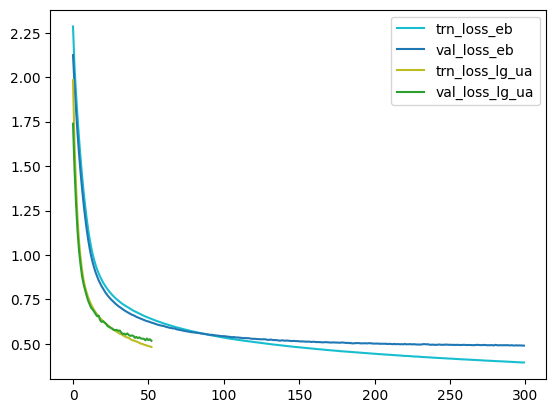

In [16]:
plt.plot(x, [e[0] for e in EB_history], "tab:cyan", label="trn_loss_eb")
plt.plot(x, [e[2] for e in EB_history], "tab:blue", label="val_loss_eb")
plt.plot(x1, [e[0] for e in LG_UA_history], "tab:olive", label="trn_loss_lg_ua")
plt.plot(x1, [e[2] for e in LG_UA_history], "tab:green", label="val_loss_lg_ua")
# plt.plot(x2, [e[0] for e in EB_LG_UA_history], "tab:orange", label="trn_loss_eb_lg_ua")
# plt.plot(x2, [e[2] for e in EB_LG_UA_history], "tab:red", label="val_loss_eb_lg_ua")
plt.legend(loc="upper right")
plt.show()


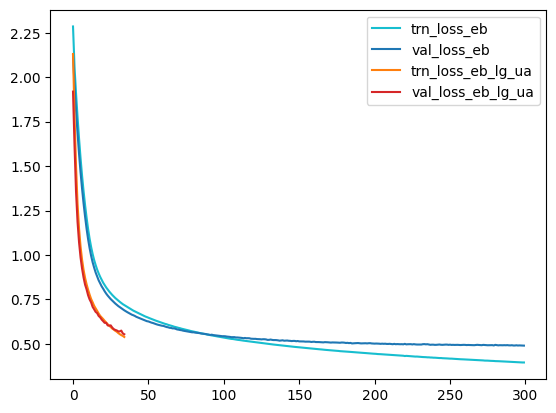

In [17]:
plt.plot(x, [e[0] for e in EB_history], "tab:cyan", label="trn_loss_eb")
plt.plot(x, [e[2] for e in EB_history], "tab:blue", label="val_loss_eb")
plt.plot(x2, [e[0] for e in EB_LG_UA_history], "tab:orange", label="trn_loss_eb_lg_ua")
plt.plot(x2, [e[2] for e in EB_LG_UA_history], "tab:red", label="val_loss_eb_lg_ua")
plt.legend(loc="upper right")
plt.show()


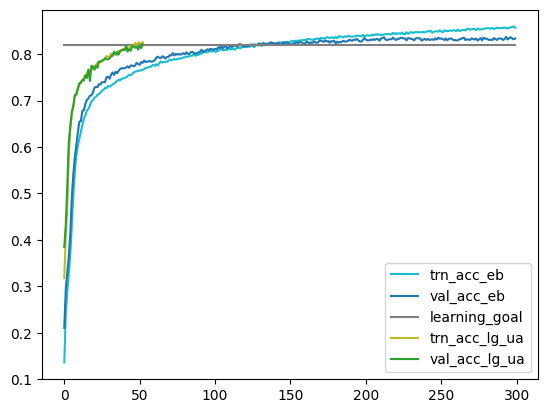

In [18]:
plt.plot(x, [e[1] for e in EB_history], "tab:cyan", label="trn_acc_eb")
plt.plot(x, [e[3] for e in EB_history], "tab:blue", label="val_acc_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x1, [e[1] for e in LG_UA_history], "tab:olive", label="trn_acc_lg_ua")
plt.plot(x1, [e[3] for e in LG_UA_history], "tab:green", label="val_acc_lg_ua")
# plt.plot(x2, [e[0] for e in EB_LG_UA_history], "tab:orange", label="trn_acc_eb_lg_ua")
# plt.plot(x2, [e[2] for e in EB_LG_UA_history], "tab:red", label="val_acc_eb_lg_ua")
plt.legend(loc="lower right")
plt.show()


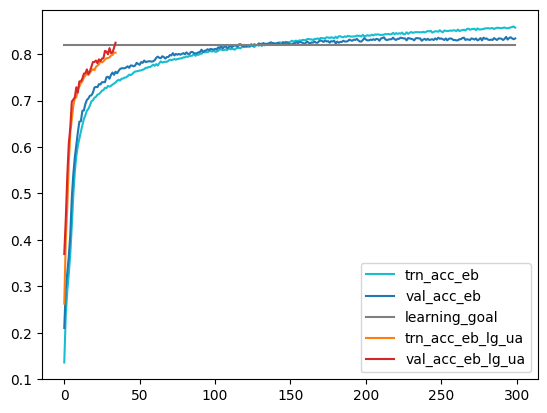

In [19]:
plt.plot(x, [e[1] for e in EB_history], "tab:cyan", label="trn_acc_eb")
plt.plot(x, [e[3] for e in EB_history], "tab:blue", label="val_acc_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x2, [e[1] for e in EB_LG_UA_history], "tab:orange", label="trn_acc_eb_lg_ua")
plt.plot(x2, [e[3] for e in EB_LG_UA_history], "tab:red", label="val_acc_eb_lg_ua")
plt.legend(loc="lower right")
plt.show()
